In [20]:
import os
import chembl_downloader
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap
from math import floor,ceil

In [71]:
# data_dir = 'C:\\Users\gorostiolam\Documents\Gorostiola Gonzalez,Marina\PROJECTS\\6_Mutants_PCM\PROTOCOLS-SCRIPTS\Python\mutants-in-pcm\data'
output_dir = 'C:\\Users\gorostiolam\Documents\Gorostiola Gonzalez, ' \
             'Marina\PROJECTS\\6_Mutants_PCM\DATA\\2_Analysis\\0_mutant_statistics\\0_family_stats'

In [57]:
def obtain_chembl_family(chembl_version: str, chunksize: int = None, data_folder: str = None):
    """Obtain assay descriptions and bioactivities annotated for mutants from ChEMBL using chembl-downloader.

    :param chembl_version: version of chembl to work with
    :param chunksize: size of chunks of data to be used (default: None)
    param data_folder: path to the folder in which the ChEMBL
    SQLite database is located or will be downloaded (default:
    pystow's default directory)
    """
    if data_folder is not None:
        os.environ['PYSTOW_HOME'] = data_folder

    chembl_file = '../../data/chembl_families.csv'
    if not os.path.isfile(chembl_file):

        query = """
            SELECT component_sequences.accession,
            protein_family_classification.l1,protein_family_classification.l2,protein_family_classification.l3,
            protein_family_classification.l4,protein_family_classification.l5
            FROM component_sequences
                LEFT JOIN component_class USING (component_id)
                LEFT JOIN protein_family_classification USING (protein_class_id)
            """

        chembl_families = chembl_downloader.query(query, version=chembl_version,
                                              prefix=['mutants-in-pcm', 'chembl'])

        # Make sure every accession appears only once. If it does not, keep the most annotated entry
        nan_counts = chembl_families.drop('accession', axis=1).isna().sum(axis=1)
        chembl_families['nan_counts'] = nan_counts

        chembl_families_unique = chembl_families.sort_values('nan_counts', ascending=True).drop_duplicates('accession')
        chembl_families_unique.drop('nan_counts', axis=1, inplace=True)

        chembl_families_unique.to_csv(chembl_file, sep='\t', index=None)

    else:
        chembl_families_unique = pd.read_csv(chembl_file, sep='\t')

    return chembl_families_unique

chembl_families = obtain_chembl_family(chembl_version='31')
chembl_families

,accession,l1,l2,l3,l4,l5
5810,Q8HZ64,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),Monoamine receptor,Trace amine receptor
2228,P50282,Enzyme,Protease,Metallo protease,Metallo protease MAM clan,Metallo protease M10A subfamily
5124,P26664,Enzyme,Protease,Serine protease,Serine protease PA clan,Serine protease S29 family
2230,P51675,Membrane receptor,Family A G protein-coupled receptor,Peptide receptor (family A GPCR),Chemokine receptor,CC chemokine receptor
5119,O15528,Enzyme,Cytochrome P450,Cytochrome P450 family 27,Cytochrome P450 family 27B,Cytochrome P450 27B1
...,...,...,...,...,...,...
10507,Q6V0L0,None,None,None,None,None
10502,Q6NT55,None,None,None,None,None
10505,Q4G0S4,None,None,None,None,None
9310,P09688,None,None,None,None,None


In [197]:
# Group smaller families in bigger families to avoid cluttering the plot
chembl_families[['l1','l2','l3','l4','l5']] = chembl_families[['l1','l2','l3','l4','l5']].fillna('Other')

chembl_families['l1'] = chembl_families['l1'].apply(lambda x: 'Other' if any([match in x for match in ['Other','Auxiliary','Unclassified','Structural',
                                                                                               'Surface']])
else x)


chembl_families['l2'] = chembl_families['l2'].apply(lambda x: 'GPCR' if any([match in x for match in
                                                                                              ['G protein-coupled']])
else x)

chembl_families['l2'] = chembl_families['l2'].apply(lambda x: 'Other' if any([match in x for match in
                                                                                              ['Primary active',
                                                                                               'Other', 'Ligase',
                                                                                               'Isomerase', 'Writer']])
else x)
chembl_families

,accession,l1,l2,l3,l4,l5
5810,Q8HZ64,Membrane receptor,GPCR,Small molecule receptor (family A GPCR),Monoamine receptor,Trace amine receptor
2228,P50282,Enzyme,Protease,Metallo protease,Metallo protease MAM clan,Metallo protease M10A subfamily
5124,P26664,Enzyme,Protease,Serine protease,Serine protease PA clan,Serine protease S29 family
2230,P51675,Membrane receptor,GPCR,Peptide receptor (family A GPCR),Chemokine receptor,CC chemokine receptor
5119,O15528,Enzyme,Cytochrome P450,Cytochrome P450 family 27,Cytochrome P450 family 27B,Cytochrome P450 27B1
...,...,...,...,...,...,...
10507,Q6V0L0,Other,Other,Other,Other,Other
10502,Q6NT55,Other,Other,Other,Other,Other
10505,Q4G0S4,Other,Other,Other,Other,Other
9310,P09688,Other,Other,Other,Other,Other


In [3]:
def read_annotated_data(chembl_version, papyrus_version, data_folder: str = None):
    if data_folder is not None:
        os.environ['PYSTOW_HOME'] = data_folder

    annotated_file = f'../../data/chembl{chembl_version}-annotated_papyrus{papyrus_version}nostereo_data_with_mutants.csv'
    annotated_data = pd.read_csv(annotated_file, sep='\t')

    return annotated_data

annotated_data = read_annotated_data('31', '05.5')
annotated_data

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CID,connectivity,target_id,AID,accession,pchembl_value_Mean,SMILES,sequence,source,Activity_class,Year
0,CHEMBL4626325,ALIJNJWQOZKBPP,A0A045ISB3_F161S,"[1992590, 1992590, 1992590, 1992590]",A0A045ISB3,5.1275,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,[
1,CHEMBL4626322,ALIJNJWQOZKBPP,A0A045ISB3_I203A,"[1992587, 1992587, 1992587, 1992587]",A0A045ISB3,7.5125,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,[
2,CHEMBL4626323,ALIJNJWQOZKBPP,A0A045ISB3_I207A,"[1992588, 1992588, 1992588, 1992588]",A0A045ISB3,6.9175,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,[
3,CHEMBL4626324,ALIJNJWQOZKBPP,A0A045ISB3_I207K,"[1992589, 1992589, 1992589, 1992589]",A0A045ISB3,6.2400,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,[
4,CHEMBL4149701,ZARADUGOWQTXRW,A0A045ISB3_WT,"[1734165, 1734165]",A0A045ISB3,4.6700,C[C@H](O)Cc1cc2c(O)c(O)cc(O)c2c(=O)o1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,[
...,...,...,...,...,...,...,...,...,...,...,...
80813,Christmann2016.compound.1413,VMJFTOSOFDEKTM,P08581_Y1230H,Christmann2016.assay,P08581,9.2220,Cn1cc(-c2cnc3ccc4c(cc(CS(=O)(=O)NCc5ncccc5)cc4...,MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNF...,Papyrus05.5_Christmann2016,NaN,2011.0
80814,Christmann2016.compound.1640,WCIGMFCFPXZRMQ,Q5S007_A2016T,Christmann2016.assay,Q5S007,7.0910,O=C(Nc1cnccc1)c1cc(-c2ccnc(F)c2)ccc1OCc1ccccc1,MASGSCQGCEEDEETLKKLIVRLNNVQEGKQIETLVQILEDLLVFT...,Papyrus05.5_Christmann2016,NaN,2012.0
80815,Christmann2016.compound.1392,YEVOZZZLKJKCCD,Q5S007_A2016T,Christmann2016.assay,Q5S007,6.8130,CNc1nc(Nc2c(OC)cc(C(=O)N3CCOCC3)cc2)ncc1Cl,MASGSCQGCEEDEETLKKLIVRLNNVQEGKQIETLVQILEDLLVFT...,Papyrus05.5_Christmann2016,NaN,2012.0
80816,Christmann2016.compound.1640,WCIGMFCFPXZRMQ,Q5S007_G2019S_A2016T,Christmann2016.assay,Q5S007,7.2130,O=C(Nc1cnccc1)c1cc(-c2ccnc(F)c2)ccc1OCc1ccccc1,MASGSCQGCEEDEETLKKLIVRLNNVQEGKQIETLVQILEDLLVFT...,Papyrus05.5_Christmann2016,NaN,2012.0


In [198]:
annotated_data_families = pd.merge(annotated_data, chembl_families, how='inner', on='accession')
annotated_data_families

,CID,connectivity,target_id,AID,accession,pchembl_value_Mean,SMILES,sequence,source,Activity_class,Year,l1,l2,l3,l4,l5
0,CHEMBL4626325,ALIJNJWQOZKBPP,A0A045ISB3_F161S,"[1992590, 1992590, 1992590, 1992590]",A0A045ISB3,5.127500,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,[,Enzyme,Hydrolase,Other,Other,Other
1,CHEMBL4626322,ALIJNJWQOZKBPP,A0A045ISB3_I203A,"[1992587, 1992587, 1992587, 1992587]",A0A045ISB3,7.512500,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,[,Enzyme,Hydrolase,Other,Other,Other
2,CHEMBL4626323,ALIJNJWQOZKBPP,A0A045ISB3_I207A,"[1992588, 1992588, 1992588, 1992588]",A0A045ISB3,6.917500,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,[,Enzyme,Hydrolase,Other,Other,Other
3,CHEMBL4626324,ALIJNJWQOZKBPP,A0A045ISB3_I207K,"[1992589, 1992589, 1992589, 1992589]",A0A045ISB3,6.240000,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2)cc1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,[,Enzyme,Hydrolase,Other,Other,Other
4,CHEMBL4149701,ZARADUGOWQTXRW,A0A045ISB3_WT,"[1734165, 1734165]",A0A045ISB3,4.670000,C[C@H](O)Cc1cc2c(O)c(O)cc(O)c2c(=O)o1,MAVRELPGAWNFRDVADTATALRPGRLFRSSELSRLDDAGRATLRR...,ChEMBL31,NaN,[,Enzyme,Hydrolase,Other,Other,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80813,CHEMBL982903,QWAXKHKRTORLEM,Q9YQ12_WT,"[491043, 491043, 491043, 491043, 491043, 491043]",Q9YQ12,10.261667,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,ChEMBL31,NaN,[,Enzyme,Protease,Cysteine protease,Cysteine protease PAC clan,Cysteine protease C3A subfamily
80814,CHEMBL984415,SAEHJKSEOLSBPF,Q9YQ12_WT,"[535386, 535386, 535386, 535386, 535386, 535386]",Q9YQ12,5.426667,O=S(=O)(c1ccccc1)N(CCNCCN(Cc1ccccc1)S(=O)(=O)c...,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,ChEMBL31,NaN,[,Enzyme,Protease,Cysteine protease,Cysteine protease PAC clan,Cysteine protease C3A subfamily
80815,CHEMBL984782,FAXGPCHRFPCXOO,Q9YQ12_WT,[488349],Q9YQ12,5.820000,CC(C)CC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CC(...,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,ChEMBL31,NaN,[,Enzyme,Protease,Cysteine protease,Cysteine protease PAC clan,Cysteine protease C3A subfamily
80816,CHEMBL990633,NNOFYWJFSHHUJW,Q9YQ12_WT,"[537468, 537468, 537468, 537468, 537468, 537468]",Q9YQ12,7.150000,O=C(N[C@H]1c2ccccc2C[C@H]1O)[C@H](Cc1ccccc1)CC...,PQITLWQRPFVTIKIEGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,ChEMBL31,NaN,[,Enzyme,Protease,Cysteine protease,Cysteine protease PAC clan,Cysteine protease C3A subfamily


In [229]:
def plot_circular_barplot_families(annotated_data_families, family_level, output_dir, subset_level=None,
                                   subset_family=None):

    # Define subset (e.g. l2 = Kinase)
    if subset_level != None:
        annotated_data_families = annotated_data_families[annotated_data_families[subset_level] == subset_family]
        file_tag = f'_subset_{subset_level}_{subset_family.replace(" ","-")}'
    else:
        file_tag = ''

    # Count number of bioactivity datapoints in total and in non-WT variants
    activity_mut = annotated_data_families[~annotated_data_families['target_id'].str.contains('WT')].groupby([family_level]).count()[['CID']].rename(columns={'CID':'activity_mut'})

    activity_all = annotated_data_families.groupby([family_level]).count()[['CID']].rename(columns={'CID':'activity_all'})

    summary_all = pd.concat([activity_mut,activity_all],axis=1)

    # Calculate ratio of mutated datapoints respect to all datapoints
    summary_all['mut_ratio'] = summary_all['activity_mut']/summary_all['activity_all']
    summary_all.to_csv(os.path.join(output_dir, f'family_stats_{family_level}{file_tag}.csv'), sep='\t')
    print(summary_all)

    # Calculate maximum log exponent that will be plotted from the data and the range leading to it
    max_value = max(summary_all['activity_all'])
    max_log_exp = int("{:e}".format(max_value).split('+')[1])
    log_exps = range(0,max_log_exp+1,1)

    # Bars are sorted
    df_sorted = summary_all.sort_values("activity_all", ascending=False)
    # Values for the x axis
    ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(df_sorted), endpoint=False)
    # Activity values
    ACTIVITIES = df_sorted["activity_all"].values
    # Mutant activity values
    MUTANT_ACTIVITIES = df_sorted["activity_mut"].values
    # Family label
    FAMILY = df_sorted.index.tolist()
    # Mutant ratio
    RATIO = df_sorted["mut_ratio"]

    GREY12 = "#1f1f1f"

    # Set default font to Bell MT
    plt.rcParams.update({"font.family": "Bell MT"})

    # Set default font color to GREY12
    plt.rcParams["text.color"] = GREY12

    # The minus glyph is not available in Bell MT
    # This disables it, and uses a hyphen
    plt.rc("axes", unicode_minus=False)

    # Colors
    COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195"]

    # Colormap
    cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)

    # Normalizer
    def round_half_up(n, decimals=0):
        multiplier = 10 ** decimals

        return math.floor(n*multiplier + 0.5) / multiplier
    norm = mpl.colors.Normalize(vmin=floor(RATIO.min()), vmax=round_half_up(RATIO.max(),1))

    # Normalized colors. Each number of tracks is mapped to a color in the
    # color scale 'cmap'
    COLORS = cmap(norm(RATIO))

    # Some layout stuff ----------------------------------------------
    # Initialize layout in polar coordinates
    fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})
    plt.yscale('symlog') # Symmetric logaritmic scale

    # Set background color to white, both axis and figure.
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    ax.set_theta_offset(1.2 * np.pi / 2)

    # Add geometries to the plot -------------------------------------
    # See the zorder to manipulate which geometries are on top

    # Add bars to represent the cumulative track lengths
    ax.bar(ANGLES, ACTIVITIES, color=COLORS, alpha=0.9, width=0.52, zorder=10)

    # Add dashed vertical lines. These are just references
    ax.vlines(ANGLES, 0, 10**max_log_exp, color=GREY12, ls=(0, (4, 4)), zorder=11)

    # Add dots to represent the mean gain
    ax.scatter(ANGLES, MUTANT_ACTIVITIES, s=60, color=GREY12, zorder=11)


    # Add labels for the regions -------------------------------------
    # Note the 'wrap()' function.
    # The '5' means we want at most 5 consecutive letters in a word,
    # but the 'break_long_words' means we don't want to break words
    # longer than 5 characters.
    FAMILY = ["\n".join(wrap(r, 15, break_long_words=False)) for r in FAMILY]
    FAMILY

    # Set the labels
    ax.set_xticks(ANGLES)
    ax.set_xticklabels(FAMILY, size=12)

    # Customize guides and annotations
    # Remove lines for polar axis (x)
    ax.xaxis.grid(False)

    # Put grid lines for radial axis (y) at 1, 10, 100, 1000, and 10000 (...) depending on the data
    ax.set_yticklabels([])
    y_ticks = [10**exp for exp in log_exps]
    ax.set_yticks(y_ticks)

    # Remove spines
    ax.spines["start"].set_color("none")
    ax.spines["polar"].set_color("none")


    # Adjust padding of the x axis labels ----------------------------
    # This is going to add extra space around the labels for the
    # ticks of the x axis.
    XTICKS = ax.xaxis.get_major_ticks()
    for tick in XTICKS:
        tick.set_pad(10)

    # Add custom annotations -----------------------------------------
    # The following represent the heights in the values of the y axis
    for log_exp in log_exps:
        PAD = 0
        POS = 10**log_exp
        ax.text(-0.2 * np.pi / 2, POS + PAD, f"10$^{log_exp}$", ha="center", size=12)

    # Add text to explain the meaning of the height of the bar and the
    # height of the dot
    ax.text(ANGLES[0]-0.042, max_value, "Total bioactivity\npoints (Log scale)", rotation=21,
            ha="center", va="top", size=10, zorder=12)
    ax.text(ANGLES[0]+ 0.012, (10**(max_log_exp-2)), "Mutant bioactivity points\n(Log scale)", rotation=-69,
            ha="center", va="center", size=10, zorder=12)

    # Add legend -----------------------------------------------------

    # First, make some room for the legend and the caption in the bottom.
    fig.subplots_adjust(bottom=0.175)

    # Create an inset axes.
    # Width and height are given by the (0.35 and 0.01) in the
    # bbox_to_anchor
    cbaxes = inset_axes(
        ax,
        width="100%",
        height="100%",
        loc="center",
        bbox_to_anchor=(0.325, 0.1, 0.35, 0.01),
        bbox_transform=fig.transFigure # Note it uses the figure.
    )

    # Create the colorbar
    cb = fig.colorbar(
        ScalarMappable(norm=norm, cmap=cmap),
        cax=cbaxes, # Use the inset_axes created above
        orientation = "horizontal"
    )

    # Remove the outline of the colorbar
    cb.outline.set_visible(False)

    # Remove tick marks
    cb.ax.xaxis.set_tick_params(size=0)

    # Set legend label and move it to the top (instead of default bottom)
    cb.set_label("Mutant ratio", size=12, labelpad=-40)

    # Add annotations ------------------------------------------------

    # Make some room for the title and subtitle above.
    fig.subplots_adjust(top=0.8)

    # Define title, subtitle, and caption
    title = "\nBioactivity datapoints distribution\naccross protein families"
    subtitle = "\n".join([
        f"Level of protein family definition (ChEMBL) = {family_level}.\n",
        "The following data was calculated for the subset:",
        f"Family level {subset_level} = {subset_family}."
    ])
    # caption = "Insert caption here"

    # And finally, add them to the plot.
    fig.text(0.1, 0.93, title, fontsize=25, weight="bold", ha="left", va="baseline")
    fig.text(0.1, 0.9, subtitle, fontsize=14, ha="left", va="top")
    # fig.text(0.5, 0.025, caption, fontsize=10, ha="center", va="baseline")

    fig

    # Save figure
    fig.savefig(os.path.join(output_dir, f'family_stats_{family_level}{file_tag}.svg'))

                      activity_mut  activity_all  mut_ratio
l1                                                         
Enzyme                        4807         55501   0.086611
Epigenetic regulator           144          3642   0.039539
Ion channel                    100          3181   0.031437
Membrane receptor              563         12798   0.043991
Other                          156          1290   0.120930
Transcription factor            61          3021   0.020192
Transporter                     58          1385   0.041877


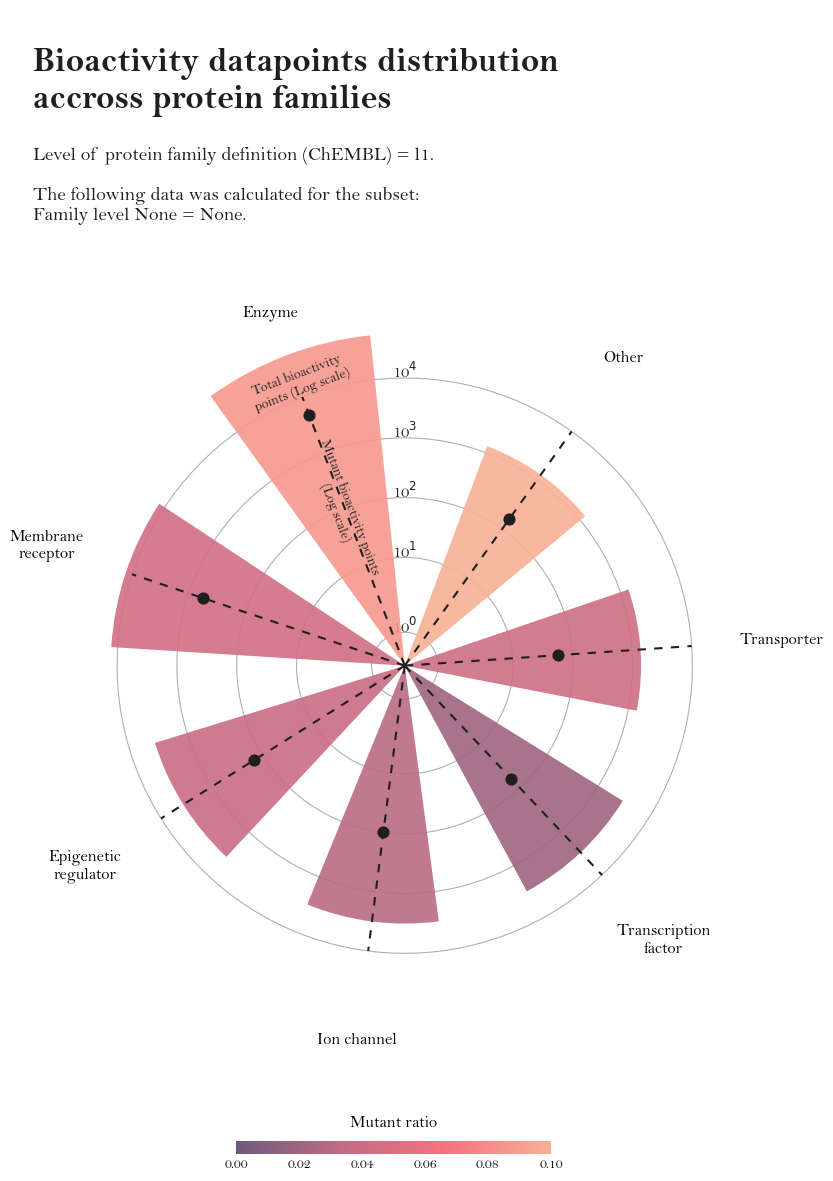

In [230]:
plot_circular_barplot_families(annotated_data_families, 'l1', output_dir, subset_level=None, subset_family=None)

                             activity_mut  activity_all  mut_ratio
l2                                                                
Cytochrome P450                        11           610   0.018033
Electrochemical transporter            55          1342   0.040984
Eraser                                 17          2248   0.007562
GPCR                                  563         12798   0.043991
Hydrolase                             526          2335   0.225268
Kinase                               3412         34368   0.099278
Ligand-gated ion channel               18           951   0.018927
Lyase                                  16           784   0.020408
Nuclear receptor                       41          2818   0.014549
Other                                 376          4001   0.093977
Oxidoreductase                        267          1366   0.195461
Phosphatase                            42           878   0.047836
Phosphodiesterase                      10          1233   0.00

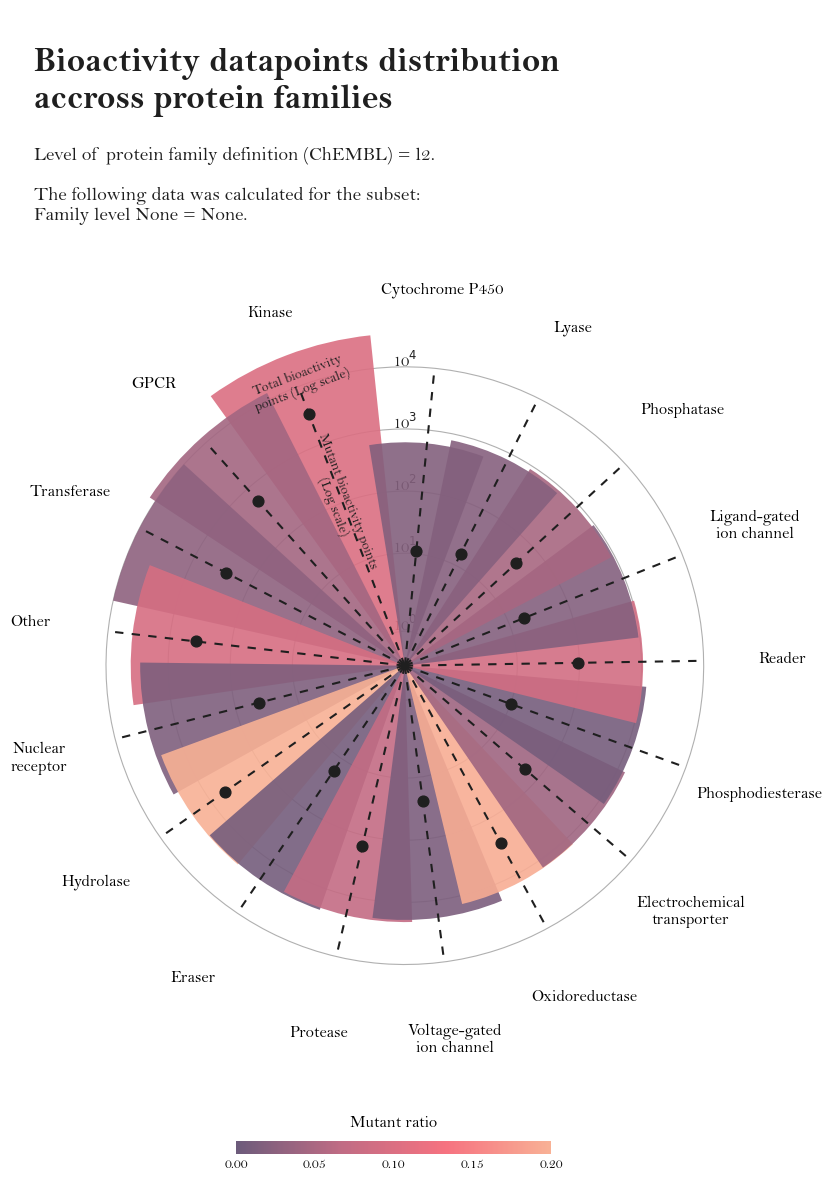

In [231]:
plot_circular_barplot_families(annotated_data_families, 'l2', output_dir, subset_level=None, subset_family=None)

                               activity_mut  activity_all  mut_ratio
l4                                                                  
AGC protein kinase group                 36          2825   0.012743
Atypical protein kinase group             7           307   0.022801
CAMK protein kinase group                 3            62   0.048387
CK1 protein kinase group                  1            13   0.076923
CMGC protein kinase group                22          2910   0.007560
Other protein kinase group               84          1255   0.066932
STE protein kinase group                  3           211   0.014218
TK protein kinase group                2692         24018   0.112083
TKL protein kinase group                564          2767   0.203831


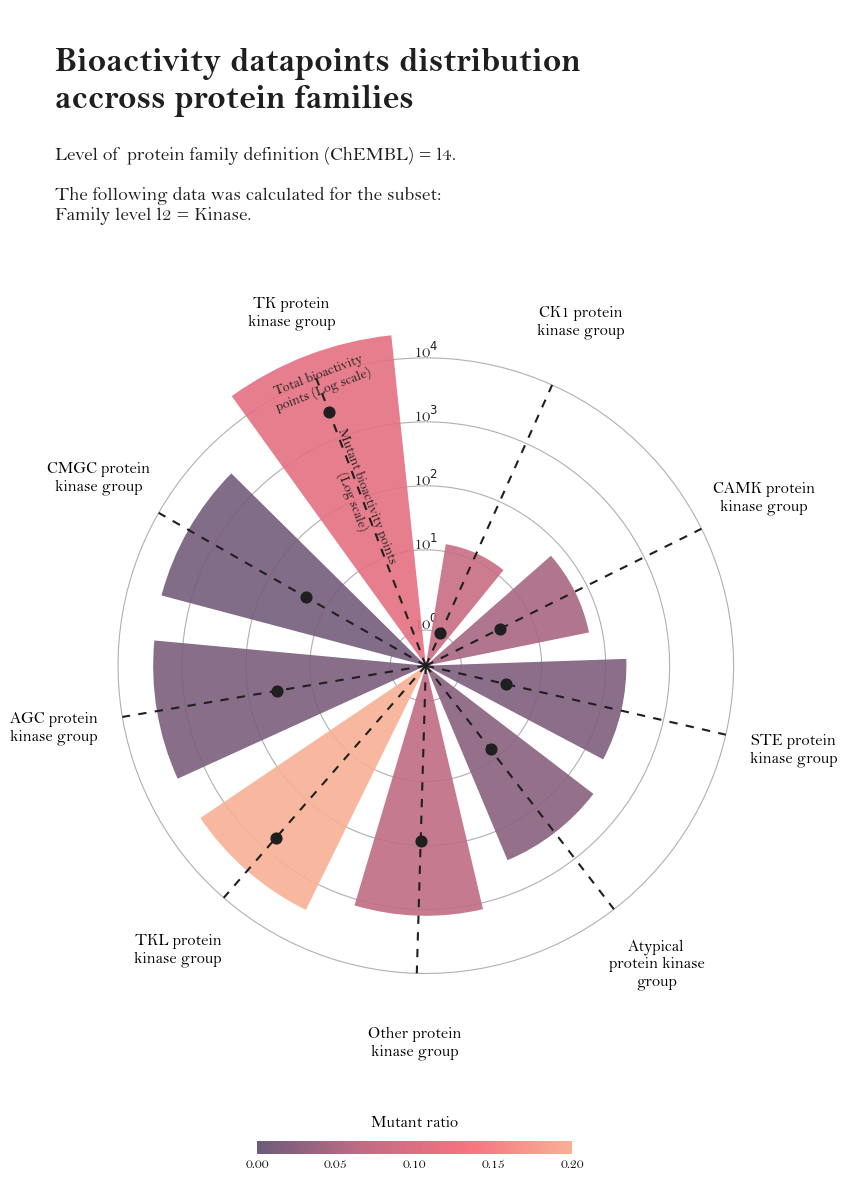

In [232]:
plot_circular_barplot_families(annotated_data_families, 'l4', output_dir, subset_level='l2', subset_family='Kinase')

                                            activity_mut  activity_all  \
l4                                                                       
Chemokine receptor                                    80           463   
Lipid-like ligand receptor (family A GPCR)            15          1668   
Monoamine receptor                                   104          4966   
Neurotransmitter receptor (family C GPCR)             12           216   
Nucleotide-like receptor (family A GPCR)             112          1606   
Other                                                  5            89   
Short peptide receptor (family A GPCR)               235          3790   

                                            mut_ratio  
l4                                                     
Chemokine receptor                           0.172786  
Lipid-like ligand receptor (family A GPCR)   0.008993  
Monoamine receptor                           0.020942  
Neurotransmitter receptor (family C GPCR)    0.055556

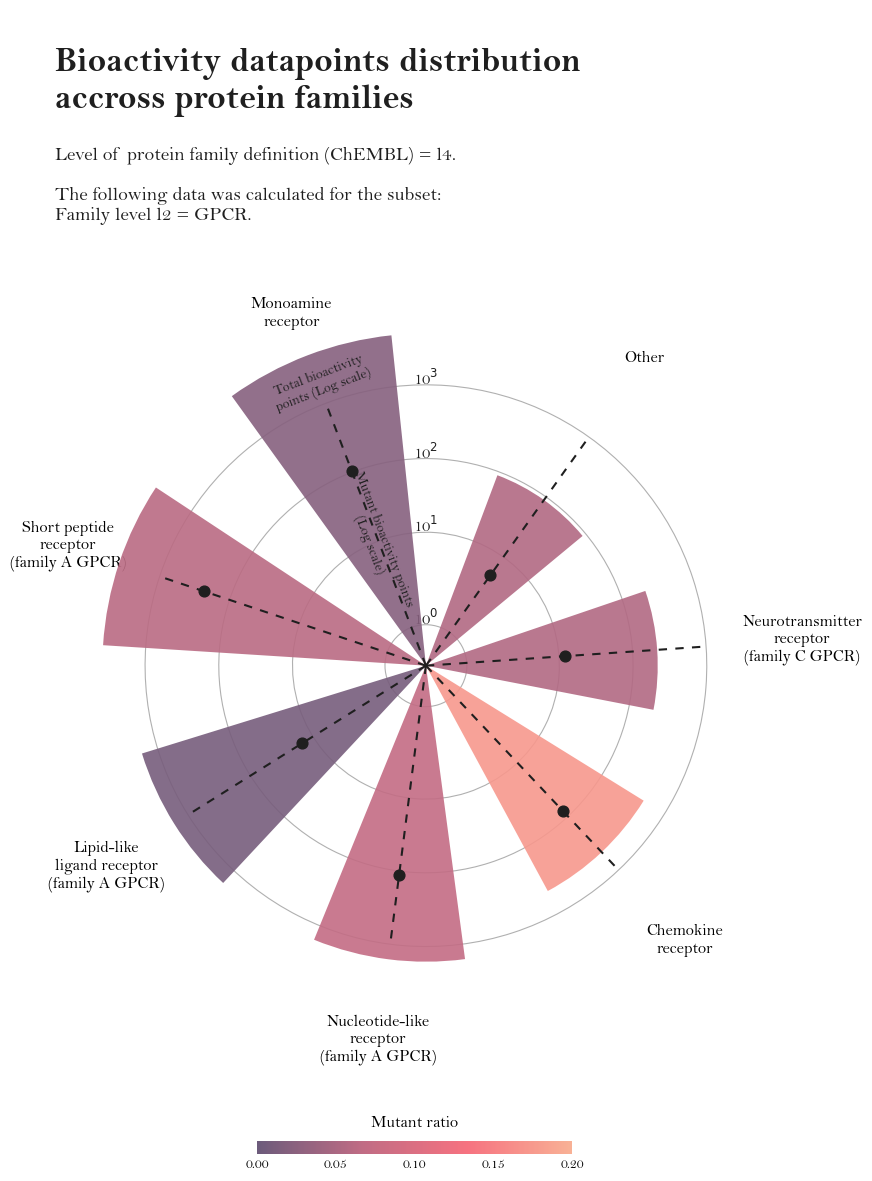

In [236]:
plot_circular_barplot_families(annotated_data_families, 'l4', output_dir, subset_level='l2', subset_family='GPCR')

                                      activity_mut  activity_all  mut_ratio
l5                                                                         
Tyrosine protein kinase Abl family             644          2208   0.291667
Tyrosine protein kinase Axl family               1           128   0.007812
Tyrosine protein kinase DDR family               2            68   0.029412
Tyrosine protein kinase EGFR family            778          8208   0.094786
Tyrosine protein kinase Eph family               1            24   0.041667
Tyrosine protein kinase FGFR family             77          1855   0.041509
Tyrosine protein kinase Fak family               2           160   0.012500
Tyrosine protein kinase JakB family             25           495   0.050505
Tyrosine protein kinase Met family             104          1951   0.053306
Tyrosine protein kinase PDGFR family           845          4443   0.190187
Tyrosine protein kinase Ret family             166          1476   0.112466
Tyrosine pro

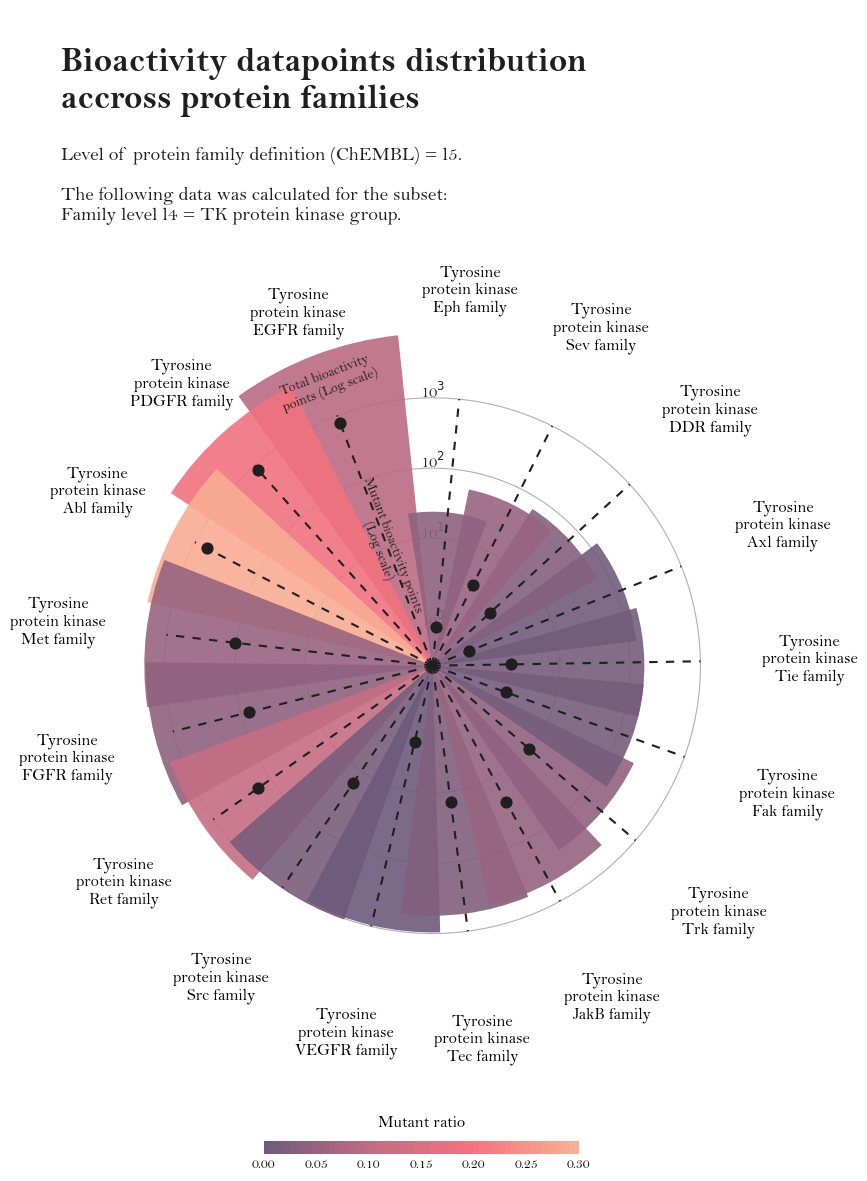

In [233]:
plot_circular_barplot_families(annotated_data_families, 'l5', output_dir, subset_level='l4', subset_family='TK protein kinase '
                                                                                               'group')

In [186]:
def read_chembl_annotated_data(data_folder: str = None):
    if data_folder is not None:
        os.environ['PYSTOW_HOME'] = data_folder

    annotated_file = f'../../data/chembl_annotated_data.csv'
    annotated_data = pd.read_csv(annotated_file, sep='\t')

    return annotated_data

chembl_annotated_data = read_chembl_annotated_data()
chembl_annotated_data

,target_id,chembl_id,assay_id,activity_id,accession,pchembl_value,activity_comment,canonical_smiles,mutation,year,sequence,pchembl_value_Mean,Activity_class
0,A0A024AXB9_WT,CHEMBL4334288,"[1834280, 1834280, 1834280, 1834280, 1834280]","[18961431, 18961432, 18961433, 18961434, 18961...",A0A024AXB9,"[6.1, 6.36, 5.7, 4.69, 5.46]","[nan, nan, nan, nan, nan]",CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(N)=O)NC(=O)[C@...,NaN,2019.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,5.662,NaN
1,A0A024AXB9_WT,CHEMBL4334289,"[1834281, 1834281, 1834281, 1834281, 1834281]","[18961437, 18961438, 18961439, 18961440, 18961...",A0A024AXB9,"[5.88, 6.21, 5.48, 4.78, 5.15]","[nan, nan, nan, nan, nan]",CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(N)=O)NC(=O)[C@...,NaN,2019.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,5.500,NaN
2,A0A024AXB9_WT,CHEMBL4334290,"[1834282, 1834282, 1834282, 1834282, 1834282, ...","[18961442, 18961443, 18961444, 18961445, 18961...",A0A024AXB9,"[7.7, 8.05, 8.1, 8.05, 8.3, 6.78]","[nan, nan, nan, nan, nan, nan]",CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(N)=O)NC(=O)[C@...,NaN,2019.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,7.830,NaN
3,A0A024AXB9_WT,CHEMBL4334291,"[1834283, 1834283, 1834283, 1834283, 1834283]","[18961448, 18961449, 18961450, 18961451, 18961...",A0A024AXB9,"[5.82, 6.6, 5.66, 5.34, 5.5]","[nan, nan, nan, nan, nan]",CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(N)=O)NC(=O)[C@...,NaN,2019.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,5.784,NaN
4,A0A024AXB9_WT,CHEMBL4338581,[1838448],[18977999],A0A024AXB9,[5.85],[nan],O=C(Nc1nc2cc(O)c(O)cc2s1)c1ccccc1Oc1ccc2cc(O)c...,NaN,2019.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,5.850,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193773,nan_WT,CHEMBL973662,"[576186, 576186, 576186, 576186, 576186, 576186]","[2663803, 2663803, 2663803, 2663813, 2663813, ...",NaN,"[6.77, 6.77, 6.77, 6.96, 6.96, 6.96]","[nan, nan, nan, nan, nan, nan]",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,NaN,2007.0,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,6.865,NaN
193774,nan_WT,CHEMBL974097,"[576188, 576188, 576188, 576188, 576188, 576188]","[2663801, 2663801, 2663801, 2663815, 2663815, ...",NaN,"[4.06, 4.06, 4.06, 6.58, 6.58, 6.58]","[nan, nan, nan, nan, nan, nan]",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,NaN,2007.0,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,5.320,NaN
193775,nan_WT,CHEMBL974511,"[576182, 576182, 576182, 576182, 576182, 576182]","[2663799, 2663799, 2663799, 2663817, 2663817, ...",NaN,"[7.96, 7.96, 7.96, 7.58, 7.58, 7.58]","[nan, nan, nan, nan, nan, nan]",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,NaN,2007.0,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,7.770,NaN
193776,nan_WT,CHEMBL977029,"[576189, 576189, 576189, 576189, 576189, 576189]","[2663800, 2663800, 2663800, 2663816, 2663816, ...",NaN,"[5.72, 5.72, 5.72, 6.72, 6.72, 6.72]","[nan, nan, nan, nan, nan, nan]",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,NaN,2007.0,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,6.220,NaN


In [200]:
chembl_annotated_data_families = pd.merge(chembl_annotated_data, chembl_families, how='inner', on='accession')
chembl_annotated_data_families

,target_id,chembl_id,assay_id,activity_id,accession,pchembl_value,activity_comment,canonical_smiles,mutation,year,sequence,pchembl_value_Mean,Activity_class,l1,l2,l3,l4,l5
0,A0A024AXB9_WT,CHEMBL4334288,"[1834280, 1834280, 1834280, 1834280, 1834280]","[18961431, 18961432, 18961433, 18961434, 18961...",A0A024AXB9,"[6.1, 6.36, 5.7, 4.69, 5.46]","[nan, nan, nan, nan, nan]",CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(N)=O)NC(=O)[C@...,NaN,2019.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,5.662,NaN,Other,Other,Other,Other,Other
1,A0A024AXB9_WT,CHEMBL4334289,"[1834281, 1834281, 1834281, 1834281, 1834281]","[18961437, 18961438, 18961439, 18961440, 18961...",A0A024AXB9,"[5.88, 6.21, 5.48, 4.78, 5.15]","[nan, nan, nan, nan, nan]",CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(N)=O)NC(=O)[C@...,NaN,2019.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,5.500,NaN,Other,Other,Other,Other,Other
2,A0A024AXB9_WT,CHEMBL4334290,"[1834282, 1834282, 1834282, 1834282, 1834282, ...","[18961442, 18961443, 18961444, 18961445, 18961...",A0A024AXB9,"[7.7, 8.05, 8.1, 8.05, 8.3, 6.78]","[nan, nan, nan, nan, nan, nan]",CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(N)=O)NC(=O)[C@...,NaN,2019.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,7.830,NaN,Other,Other,Other,Other,Other
3,A0A024AXB9_WT,CHEMBL4334291,"[1834283, 1834283, 1834283, 1834283, 1834283]","[18961448, 18961449, 18961450, 18961451, 18961...",A0A024AXB9,"[5.82, 6.6, 5.66, 5.34, 5.5]","[nan, nan, nan, nan, nan]",CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(N)=O)NC(=O)[C@...,NaN,2019.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,5.784,NaN,Other,Other,Other,Other,Other
4,A0A024AXB9_WT,CHEMBL4338581,[1838448],[18977999],A0A024AXB9,[5.85],[nan],O=C(Nc1nc2cc(O)c(O)cc2s1)c1ccccc1Oc1ccc2cc(O)c...,NaN,2019.0,AETDEDHAHWLEARMLLDNIYLQDGLIASLYRPEADKVAAIEGEFK...,5.850,NaN,Other,Other,Other,Other,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193773,nan_WT,CHEMBL973662,"[576186, 576186, 576186, 576186, 576186, 576186]","[2663803, 2663803, 2663803, 2663813, 2663813, ...",NaN,"[6.77, 6.77, 6.77, 6.96, 6.96, 6.96]","[nan, nan, nan, nan, nan, nan]",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,NaN,2007.0,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,6.865,NaN,Other,Other,Other,Other,Other
193774,nan_WT,CHEMBL974097,"[576188, 576188, 576188, 576188, 576188, 576188]","[2663801, 2663801, 2663801, 2663815, 2663815, ...",NaN,"[4.06, 4.06, 4.06, 6.58, 6.58, 6.58]","[nan, nan, nan, nan, nan, nan]",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,NaN,2007.0,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,5.320,NaN,Other,Other,Other,Other,Other
193775,nan_WT,CHEMBL974511,"[576182, 576182, 576182, 576182, 576182, 576182]","[2663799, 2663799, 2663799, 2663817, 2663817, ...",NaN,"[7.96, 7.96, 7.96, 7.58, 7.58, 7.58]","[nan, nan, nan, nan, nan, nan]",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,NaN,2007.0,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,7.770,NaN,Other,Other,Other,Other,Other
193776,nan_WT,CHEMBL977029,"[576189, 576189, 576189, 576189, 576189, 576189]","[2663800, 2663800, 2663800, 2663816, 2663816, ...",NaN,"[5.72, 5.72, 5.72, 6.72, 6.72, 6.72]","[nan, nan, nan, nan, nan, nan]",CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,NaN,2007.0,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,6.220,NaN,Other,Other,Other,Other,Other


In [224]:
def plot_circular_barplot_families_newannotations(annotated_data_families, family_level, output_dir,
                                                  subset_level=None,subset_family=None):

    # Define subset (e.g. l2 = Kinase)
    if subset_level != None:
        annotated_data_families = annotated_data_families[annotated_data_families[subset_level] == subset_family]
        file_tag = f'_subset_{subset_level}_{subset_family.replace(" ","-")}'
    else:
        file_tag = ''

    # Count number of WT bioactivity datapoints in total and those that were not previously defined in ChEMBL
    mut_new = annotated_data_families[~annotated_data_families['target_id'].str.contains('WT') &
                                      chembl_annotated_data['mutation'].isna()].groupby([family_level]).count()[['chembl_id']].rename(columns={'chembl_id':'mut_new'})

    mut_all = annotated_data_families[~annotated_data_families['target_id'].str.contains('WT')].\
        groupby([family_level]).count()[['chembl_id']].rename(columns={'chembl_id':'mut_all'})

    summary_all = pd.concat([mut_new,mut_all],axis=1)

    # Calculate ratio of mutated datapoints respect to all datapoints
    summary_all['mut_ratio'] = summary_all['mut_new']/summary_all['mut_all']
    summary_all['mut_ratio'] = summary_all['mut_ratio'].fillna(value=0)
    summary_all.to_csv(os.path.join(output_dir, f'family_stats_ChEMBLNewAnnotations_{family_level}{file_tag}.csv'), sep='\t')
    print(summary_all)

    # Calculate maximum log exponent that will be plotted from the data and the range leading to it
    max_value = max(summary_all['mut_all'])
    max_log_exp = int("{:e}".format(max_value).split('+')[1])
    log_exps = range(0,max_log_exp+1,1)

    # Bars are sorted
    df_sorted = summary_all.sort_values("mut_all", ascending=False)
    # Values for the x axis
    ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(df_sorted), endpoint=False)
    # Activity values
    ACTIVITIES = df_sorted["mut_all"].values
    # Mutant activity values
    MUTANT_ACTIVITIES = df_sorted["mut_new"].values
    # Family label
    FAMILY = df_sorted.index.tolist()
    # Mutant ratio
    RATIO = df_sorted["mut_ratio"]

    GREY12 = "#1f1f1f"

    # Set default font to Bell MT
    plt.rcParams.update({"font.family": "Bell MT"})

    # Set default font color to GREY12
    plt.rcParams["text.color"] = GREY12

    # The minus glyph is not available in Bell MT
    # This disables it, and uses a hyphen
    plt.rc("axes", unicode_minus=False)

    # Colors
    COLORS = sns.color_palette("mako", as_cmap=False)[1:]

    # Colormap
    cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)

    # Normalizer
    def round_half_up(n, decimals=0):
        multiplier = 10 ** decimals

        return floor(n*multiplier + 0.5) / multiplier
    norm = mpl.colors.Normalize(vmin=floor(RATIO.min()), vmax=round_half_up(RATIO.max(),1))

    # Normalized colors. Each number of tracks is mapped to a color in the
    # color scale 'cmap'
    COLORS = cmap(norm(RATIO))

    # Some layout stuff ----------------------------------------------
    # Initialize layout in polar coordinates
    fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})
    plt.yscale('symlog') # Symmetric logaritmic scale

    # Set background color to white, both axis and figure.
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    ax.set_theta_offset(1.2 * np.pi / 2)

    # Add geometries to the plot -------------------------------------
    # See the zorder to manipulate which geometries are on top

    # Add bars to represent the cumulative track lengths
    ax.bar(ANGLES, ACTIVITIES, color=COLORS, alpha=0.9, width=0.52, zorder=10)

    # Add dashed vertical lines. These are just references
    ax.vlines(ANGLES, 0, 10**max_log_exp, color=GREY12, ls=(0, (4, 4)), zorder=11)

    # Add dots to represent the mean gain
    ax.scatter(ANGLES, MUTANT_ACTIVITIES, s=60, color=GREY12, zorder=11)


    # Add labels for the regions -------------------------------------
    # Note the 'wrap()' function.
    # The '5' means we want at most 5 consecutive letters in a word,
    # but the 'break_long_words' means we don't want to break words
    # longer than 5 characters.
    FAMILY = ["\n".join(wrap(r, 15, break_long_words=False)) for r in FAMILY]
    FAMILY

    # Set the labels
    ax.set_xticks(ANGLES)
    ax.set_xticklabels(FAMILY, size=12)

    # Customize guides and annotations
    # Remove lines for polar axis (x)
    ax.xaxis.grid(False)

    # Put grid lines for radial axis (y) at 1, 10, 100, 1000, and 10000 (...) depending on the data
    ax.set_yticklabels([])
    y_ticks = [10**exp for exp in log_exps]
    ax.set_yticks(y_ticks)

    # Remove spines
    ax.spines["start"].set_color("none")
    ax.spines["polar"].set_color("none")


    # Adjust padding of the x axis labels ----------------------------
    # This is going to add extra space around the labels for the
    # ticks of the x axis.
    XTICKS = ax.xaxis.get_major_ticks()
    for tick in XTICKS:
        tick.set_pad(10)

    # Add custom annotations -----------------------------------------
    # The following represent the heights in the values of the y axis
    for log_exp in log_exps:
        PAD = 0
        POS = 10**log_exp
        ax.text(-0.2 * np.pi / 2, POS + PAD, f"10$^{log_exp}$", ha="center", size=12)

    # Add text to explain the meaning of the height of the bar and the
    # height of the dot
    ax.text(ANGLES[0]-0.042, max_value, "Total mutant bioactivity\npoints (Log scale)", rotation=21,
            ha="center", va="top", size=10, zorder=12)
    ax.text(ANGLES[0]+ 0.012, (10**(max_log_exp-2)), "New mutant bioactivity points\n(Log scale)", rotation=-69,
            ha="center", va="center", size=10, zorder=12)

    # Add legend -----------------------------------------------------

    # First, make some room for the legend and the caption in the bottom.
    fig.subplots_adjust(bottom=0.175)

    # Create an inset axes.
    # Width and height are given by the (0.35 and 0.01) in the
    # bbox_to_anchor
    cbaxes = inset_axes(
        ax,
        width="100%",
        height="100%",
        loc="center",
        bbox_to_anchor=(0.325, 0.1, 0.35, 0.01),
        bbox_transform=fig.transFigure # Note it uses the figure.
    )

    # Create the colorbar
    cb = fig.colorbar(
        ScalarMappable(norm=norm, cmap=cmap),
        cax=cbaxes, # Use the inset_axes created above
        orientation = "horizontal"
    )

    # Remove the outline of the colorbar
    cb.outline.set_visible(False)

    # Remove tick marks
    cb.ax.xaxis.set_tick_params(size=0)

    # Set legend label and move it to the top (instead of default bottom)
    cb.set_label("New mutant annotation ratio", size=12, labelpad=-40)

    # Add annotations ------------------------------------------------

    # Make some room for the title and subtitle above.
    fig.subplots_adjust(top=0.8)

    # Define title, subtitle, and caption
    title = "\nChEMBL mutant bioactivity datapoints\ndistribution accross protein families"
    subtitle = "\n".join([
        f"Level of protein family definition (ChEMBL) = {family_level}.\n",
        "The following data was calculated for the subset:",
        f"Family level {subset_level} = {subset_family}."
    ])
    # caption = "Insert caption here"

    # And finally, add them to the plot.
    fig.text(0.1, 0.93, title, fontsize=25, weight="bold", ha="left", va="baseline")
    fig.text(0.1, 0.9, subtitle, fontsize=14, ha="left", va="top")
    # fig.text(0.5, 0.025, caption, fontsize=10, ha="center", va="baseline")

    fig

    # Save figure
    fig.savefig(os.path.join(output_dir, f'family_stats_ChEMBLNewAnnotations_{family_level}{file_tag}.svg'))

                      mut_new  mut_all  mut_ratio
l1                                               
Enzyme                    251     2689   0.093343
Epigenetic regulator       16      144   0.111111
Ion channel                 5      100   0.050000
Membrane receptor          64      563   0.113677
Other                      22      162   0.135802
Transcription factor       12       61   0.196721
Transporter                 1       58   0.017241


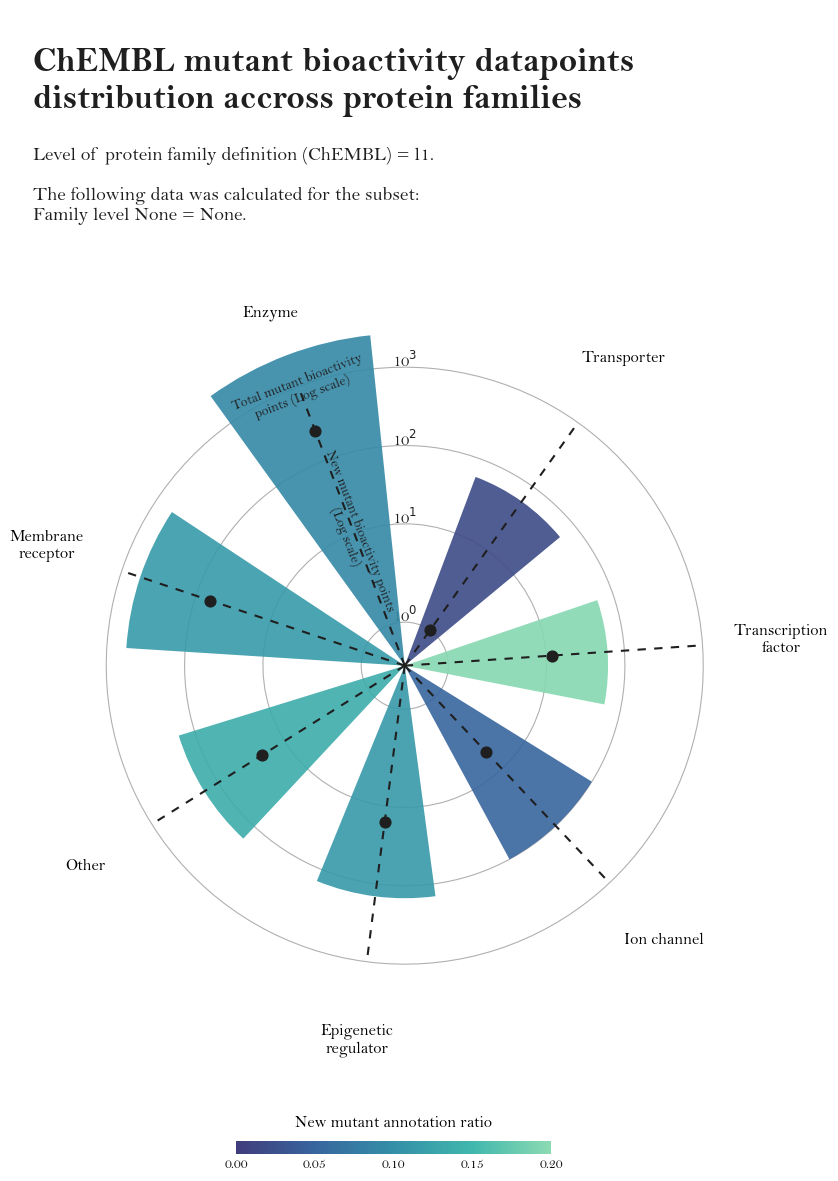

In [225]:
plot_circular_barplot_families_newannotations(chembl_annotated_data_families, 'l1', output_dir)

                             mut_new  mut_all  mut_ratio
l2                                                      
Cytochrome P450                  9.0       11   0.818182
Eraser                           3.0       17   0.176471
GPCR                            64.0      563   0.113677
Hydrolase                       62.0      529   0.117202
Kinase                          72.0     1421   0.050669
Ligand-gated ion channel         4.0       18   0.222222
Nuclear receptor                12.0       41   0.292683
Other                           42.0      382   0.109948
Oxidoreductase                  37.0      269   0.137546
Phosphatase                     15.0       42   0.357143
Phosphodiesterase                8.0       10   0.800000
Protease                        28.0      152   0.184211
Reader                           7.0       94   0.074468
Transferase                      8.0      133   0.060150
Electrochemical transporter      NaN       55   0.000000
Lyase                          

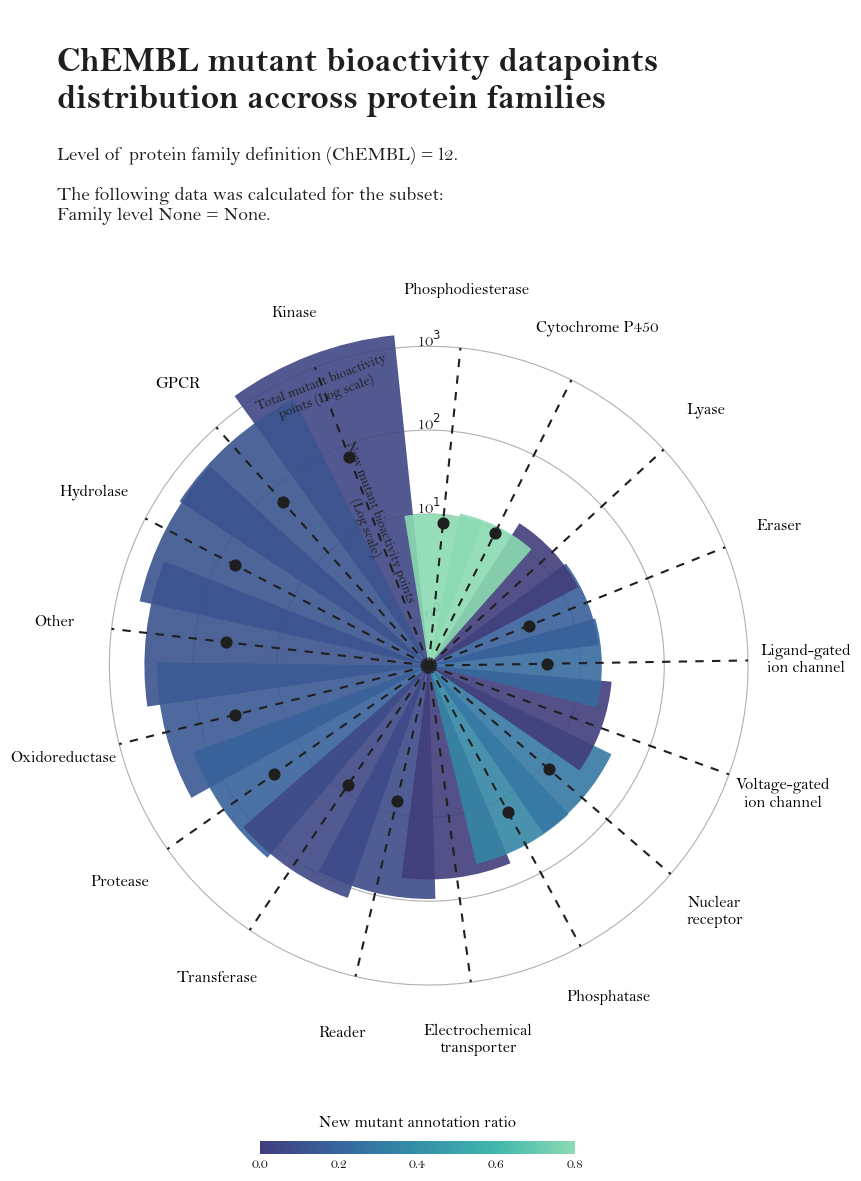

In [226]:
plot_circular_barplot_families_newannotations(chembl_annotated_data_families, 'l2', output_dir)

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


                               mut_new  mut_all  mut_ratio
l4                                                        
AGC protein kinase group           4.0       30   0.133333
CAMK protein kinase group          1.0        3   0.333333
CMGC protein kinase group          6.0       18   0.333333
Other protein kinase group         7.0       29   0.241379
STE protein kinase group           1.0        3   0.333333
TK protein kinase group           27.0      870   0.031034
TKL protein kinase group          26.0      460   0.056522
Atypical protein kinase group      NaN        7   0.000000
CK1 protein kinase group           NaN        1   0.000000


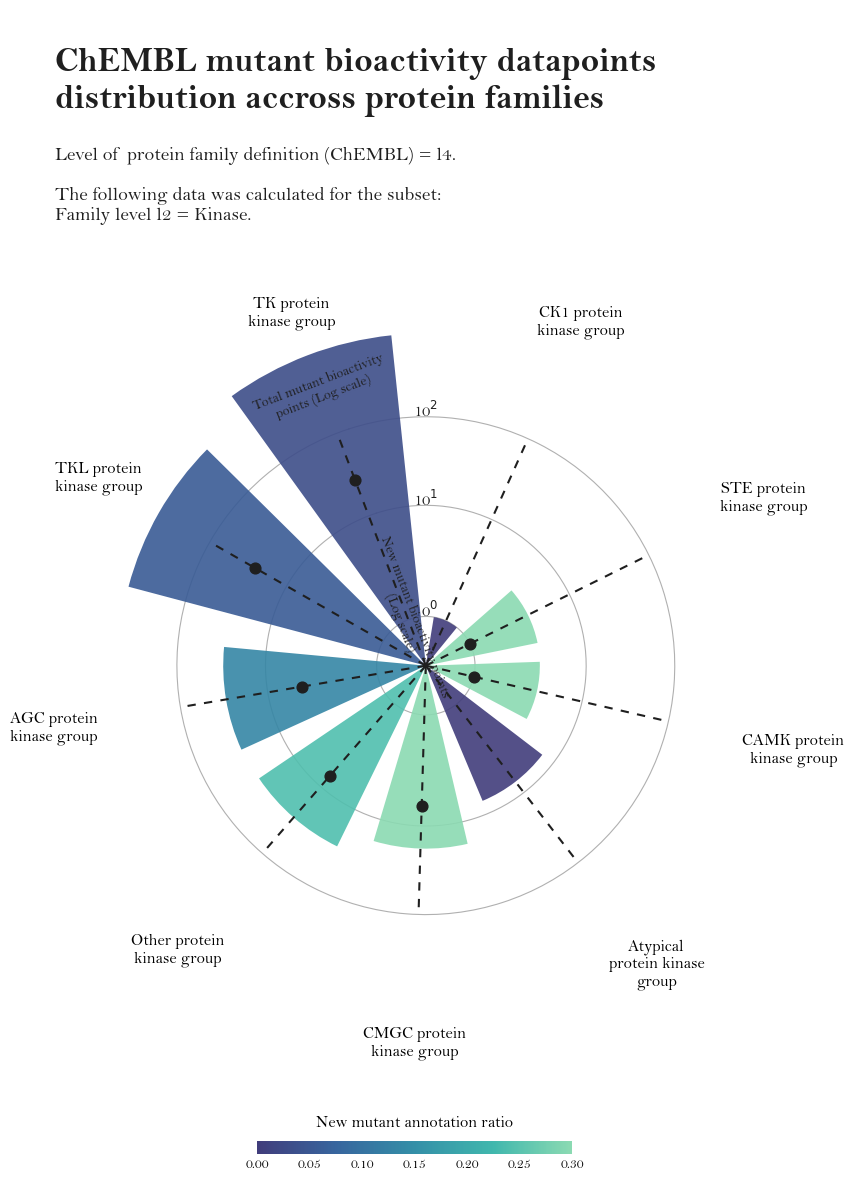

In [227]:
plot_circular_barplot_families_newannotations(chembl_annotated_data_families, 'l4', output_dir, subset_level='l2', subset_family='Kinase')

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


                                            mut_new  mut_all  mut_ratio
l4                                                                     
Lipid-like ligand receptor (family A GPCR)      2.0       15   0.133333
Monoamine receptor                             17.0      104   0.163462
Nucleotide-like receptor (family A GPCR)       12.0      112   0.107143
Short peptide receptor (family A GPCR)         33.0      235   0.140426
Chemokine receptor                              NaN       80   0.000000
Neurotransmitter receptor (family C GPCR)       NaN       12   0.000000
Other                                           NaN        5   0.000000


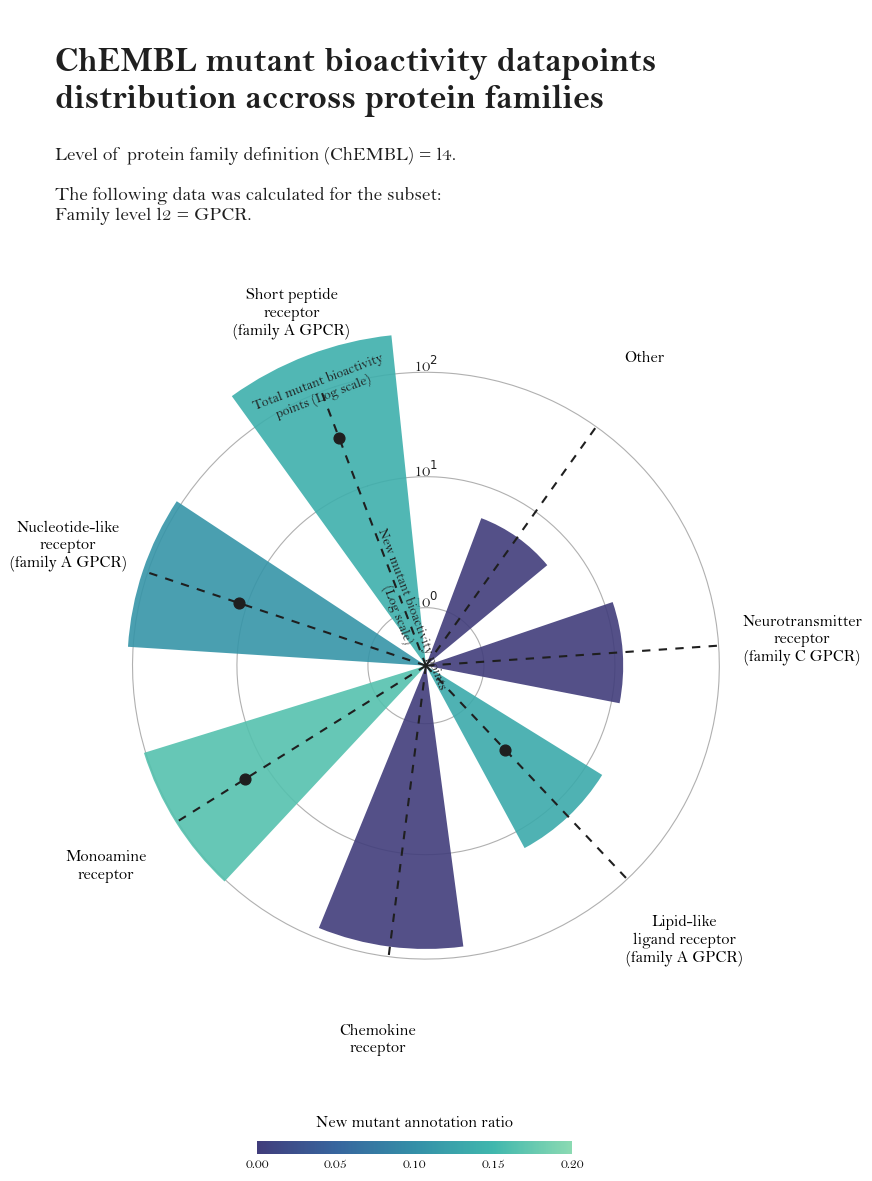

In [237]:
plot_circular_barplot_families_newannotations(chembl_annotated_data_families, 'l4', output_dir, subset_level='l2',
                                              subset_family='GPCR')

C:\Users\gorostiolam\AppData\Local\Continuum\anaconda3\envs\mutants-in-pcm\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


                                      mut_new  mut_all  mut_ratio
l5                                                               
Tyrosine protein kinase Abl family        4.0      141   0.028369
Tyrosine protein kinase EGFR family      14.0      379   0.036939
Tyrosine protein kinase FGFR family       1.0       22   0.045455
Tyrosine protein kinase Fak family        2.0        2   1.000000
Tyrosine protein kinase Ret family        3.0       42   0.071429
Tyrosine protein kinase Src family        3.0       16   0.187500
Tyrosine protein kinase Axl family        NaN        1   0.000000
Tyrosine protein kinase DDR family        NaN        2   0.000000
Tyrosine protein kinase Eph family        NaN        1   0.000000
Tyrosine protein kinase JakB family       NaN       25   0.000000
Tyrosine protein kinase Met family        NaN       28   0.000000
Tyrosine protein kinase PDGFR family      NaN      180   0.000000
Tyrosine protein kinase Sev family        NaN        3   0.000000
Tyrosine p

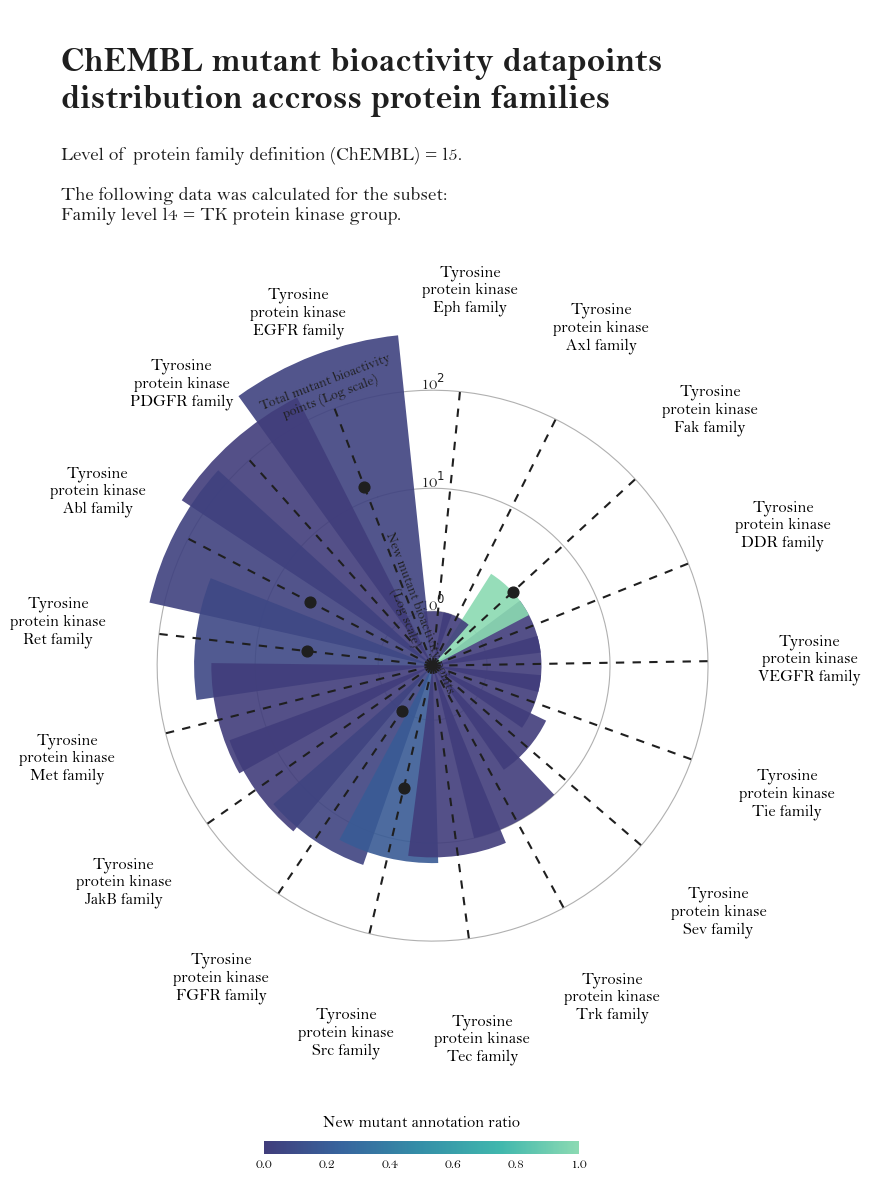

In [228]:
plot_circular_barplot_families_newannotations(chembl_annotated_data_families, 'l5', output_dir, subset_level='l4',
                                              subset_family='TK protein kinase group')